# Factors That Lead to Incorrectly Called Strikes

![Angel Hernandez](https://www.jsonline.com/gcdn/presto/2022/04/25/USAT/e7a5cca6-98e0-478c-8e8f-fa21dbd4656c-AP_Brewers_Phillies_Baseball.jpg?crop=2946,1921,x264,y102)

### by John Nahra

In [1]:
#import basic packages
import pandas as pd
import numpy as np

In [2]:
#import and download the entire lahman database to current working directory
from pybaseball.lahman import *
download_lahman()

#a table of all player biographical info and ids
people = people()

In [3]:
#read in csv file of player names and IDs
ids = pd.read_csv('data/player_ids.csv')

-Import statcast data for the 2023 season
<br> -Includes only called strikes and balls
<br> -Excludes pitches that have missing values for zone (how I determine missed calls) and effective speed (an independent variable in models)
<br> -Save to csv file and comment out so I don't need to download every time

In [4]:
#from pybaseball import statcast

In [5]:
#pitches_full = statcast(start_dt="2023-03-30", end_dt="2023-09-25",verbose=True)

In [6]:
#pitches_full = pitches_full.loc[(pitches_full['description'] == 'called_strike') | (pitches_full['description'] == 'ball')]

In [7]:
#pitches_full = pitches_full[pitches_full['zone'].notna()]

In [8]:
#pitches_full = pitches_full[pitches_full['effective_speed'].notna()]

In [9]:
#pitches_full.to_csv('mlb_2023_full.csv')

In [10]:
#pitches_full.info()

In [11]:
#read in statcast data
pitches = pd.read_csv('data/mlb_2023_full.csv')

## DF Merging, Data Exploration, Feature Engineering, Data Filtering, Outlier Removal

In [12]:
#change ids to only include IDs and player name
ids = ids[['MLBID','MLBNAME','IDPLAYER']]
#drop missing values
ids = ids.dropna()
#change to integer type
ids['MLBID'] = ids['MLBID'].astype(int)

In [13]:
#merge IDs data to statcast data 
pitches = pitches.merge(ids,left_on='batter',right_on='MLBID')
#remove duplicate player name
pitches = pitches.drop('player_name',axis=1)
#rename player name column
pitches = pitches.rename(columns={'MLBNAME':'player_name'})

In [14]:
#merge people info df with statcast pitches info df
pitches = pitches.merge(people,left_on='IDPLAYER',right_on='playerID')

In [15]:
#convert player debut to datetime
pitches['debut'] = pd.to_datetime(pitches['debut'])

In [16]:
#convert game date to datetime
pitches['game_date'] = pd.to_datetime(pitches['game_date'])

In [17]:
#create variable time since debut in days
pitches['time_since_debut'] = (pitches['game_date'] - pitches['debut']).dt.days

In [18]:
#download df of MLB allstars
allstar = all_star_full()

In [19]:
#create list of unique allstars
allstar_list = list(set(allstar['playerID']))

In [20]:
#create function that returns 1 if the hitter during the pitch has ever been an allstar and 0 otherwise
def allstar_player(df,col):
    if df[col] in allstar_list:
        return 1
    else:
        return 0

#applies function to new column
pitches['batter_allstar'] = pitches.apply(lambda x: allstar_player(x,'playerID'),axis=1)

In [21]:
#creates a copy of IDs df for pitchers
pitcher_ids = ids.copy()

In [22]:
#rename names and IDs to specify pitchers
pitcher_ids.rename({'MLBNAME':'pitcher_name','IDPLAYER':'pitcher_id'},axis=1,inplace=True)

In [23]:
#merge pitcher IDs into statcast pitches data
pitches = pitches.merge(pitcher_ids,left_on='pitcher',right_on='MLBID')

In [24]:
#apply function to create column that specifies whether pitcher has ever been an all star
pitches['pitcher_allstar'] = pitches.apply(lambda x: allstar_player(x,'pitcher_id'),axis=1)

In [25]:
#creates column run differential defined as the current hitting team's score minus the fielding team's score
pitches['run_diff'] = pitches['bat_score'] - pitches['fld_score']

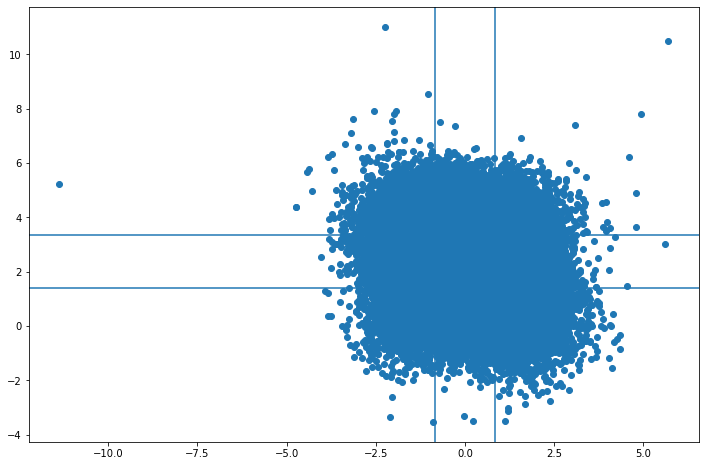

In [26]:
#import matplotlib, create a plot of all pitches and lines designate one batter's version of a strike zone
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(pitches['plate_x'],pitches['plate_z'])
plt.axhline(y=pitches['sz_top'][0])
plt.axhline(y=pitches['sz_bot'][0])
plt.axvline(-0.83)
plt.axvline(0.83);

In [27]:
#create a column that is the total height of a batter's strike zone
pitches['sz_height'] = pitches['sz_top']-pitches['sz_bot']

In [28]:
#create a function that returns 1 if the pitch is above or below the strike zone else 0
def high_or_low(df):
    if (df['plate_z']>df['sz_top'] or df['plate_z']<df['sz_bot']):
        return 1
    else:
        return 0

#apply function to create a new column
pitches['high_or_low_pitch'] = pitches.apply(high_or_low,axis=1)

In [29]:
#creates variable that combines pitcher and batter handedness
pitches['handed_matchup'] = pitches['p_throws'] + '-' + pitches['bats']

In [30]:
#creates variable that includes height as a variable if the pitch is high or low
pitches['height*hi_lo'] = pitches['height']*pitches['high_or_low_pitch']

In [31]:
#looks at descriptive statistics for plate coordinates of called strikes
pitches[pitches['description']=='called_strike'][['plate_x','plate_z']].describe()

,plate_x,plate_z
count,98264.000000,98264.000000
mean,0.012991,2.376421
std,0.521235,0.546351
min,-1.380000,1.060000
25%,-0.430000,1.930000
50%,0.020000,2.340000
75%,0.450000,2.800000
max,1.390000,5.410000


In [32]:
#limits data only to coordinates that were called strikes
pitches = pitches.loc[(pitches['plate_x']<=1.39) & (pitches['plate_x']>=-1.38) & (pitches['plate_z']<=5.41) & (pitches['plate_z']>=1.06)]

In [33]:
#creates a unique plate appearance ID
pitches['pa'] = pitches['game_pk'].astype(str) + '-' + pitches['at_bat_number'].astype(str)

In [34]:
#imports seaborn
import seaborn as sns

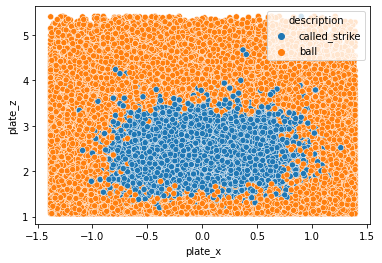

In [35]:
#creates plot of pitch coordinates colored by call
sns.scatterplot(data = pitches, x = 'plate_x', y = 'plate_z', hue = 'description');

In [36]:
#creates a function that classifies pitch based on call and whether it was missed
def true_pitch(df):
    if df['zone']>10 and df['description']=='ball':
        return 'true ball'
    elif df['zone']>10 and df['description']!='ball':
        return 'false called_strike'
    elif df['zone']<=10 and df['description']!='ball':
        return 'true called_strike'
    else:
        return 'false ball'

In [37]:
#applies function to create dependent variable
pitches['true_pitch'] = pitches.apply(true_pitch,axis=1)

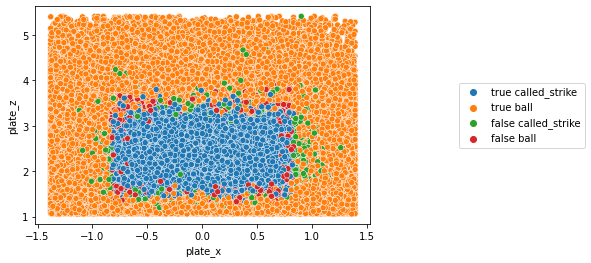

In [38]:
#creates scatterplot to look at pitch call type locations
sns.scatterplot(data = pitches, x = 'plate_x', y = 'plate_z', hue = 'true_pitch').legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1);

In [39]:
#creates new df that only includes false called strikes
false_strikes = pitches.loc[pitches['true_pitch'] == 'false called_strike']

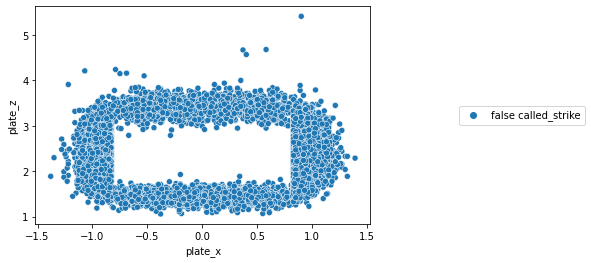

In [40]:
#creates scatterplot of new df
sns.scatterplot(data = false_strikes, x = 'plate_x', y = 'plate_z', hue = 'true_pitch').legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1);

In [41]:
#creates 4 dfs of different false called strike types
high_false_strikes = false_strikes.loc[(false_strikes['plate_z']>2.5) & (false_strikes['plate_x']>=-.83) & (false_strikes['plate_x']<=.83)]
low_false_strikes = false_strikes.loc[(false_strikes['plate_z']<2.5) & (false_strikes['plate_x']>=-.83) & (false_strikes['plate_x']<=.83)]
left_false_strikes = false_strikes.loc[(false_strikes['plate_x']<0) & (false_strikes['plate_x']<-.83)]
right_false_strikes = false_strikes.loc[(false_strikes['plate_x']>0) & (false_strikes['plate_x']>.83)]

In [42]:
#creates a function that utilizes 1.5*IQR to find outliers
false_strike_types = [{'High':high_false_strikes},{'Low':low_false_strikes},{'Left':left_false_strikes},{'Right':right_false_strikes}]
def outlier_finder(df):   
    x_Q3 = df.describe()['plate_x']['75%']
    x_Q1 = df.describe()['plate_x']['25%']
    z_Q3 = df.describe()['plate_z']['75%']
    z_Q1 = df.describe()['plate_z']['25%']
    x_lower_bound = x_Q1 - 1.5*(x_Q3-x_Q1)
    x_upper_bound = x_Q3 + 1.5*(x_Q3-x_Q1)
    z_lower_bound = z_Q1 - 1.5*(z_Q3-z_Q1)
    z_upper_bound = z_Q3 + 1.5*(z_Q3-z_Q1)
    print(f'X outliers lie outside the range ({x_lower_bound},{x_upper_bound})')
    print(f'Z outliers lie outside the range ({z_lower_bound},{z_upper_bound})')

In [43]:
#applies function to each type of false called strike
for strike in false_strike_types:
    for name,zone in strike.items():
        print(name)
        outlier_finder(zone)

High
X outliers lie outside the range (-1.535,1.465)
Z outliers lie outside the range (2.9450000000000003,3.865)
Low
X outliers lie outside the range (-1.5237500000000002,1.52625)
Z outliers lie outside the range (1.0949999999999998,1.8550000000000004)
Left
X outliers lie outside the range (-1.095,-0.7350000000000001)
Z outliers lie outside the range (0.9449999999999992,3.785000000000001)
Right
X outliers lie outside the range (0.72,1.1199999999999999)
Z outliers lie outside the range (1.0199999999999998,3.74)


In [44]:
#Uses outlier output to constrain data
pitches = pitches.loc[(pitches['plate_z']<3.86) |
           (pitches['plate_z']>1.09) |
           (pitches['plate_x']<1.11) |
           (pitches['plate_x']>-1.09)]

In [45]:
#sort data by plate appearance and pitch number
pitches = pitches.sort_values(by=['pa','pitch_number'])

In [46]:
#creates a function that returns 1 if there was a false ball earlier in at bat, which creates the potential for the
#umpire to provide a makeup call with a false called strike
pa = pitches['pa'].iloc[0]
previous_pitches = []
def makeup_call(df):
    global pa
    global previous_pitches
    if df['pa'] != pa:
        pa = df['pa']
        previous_pitches = []
        previous_pitches.append(df['true_pitch'])
        return 0
    else:
        if 'false ball' in previous_pitches:
            previous_pitches.append(df['true_pitch'])
            return 1
        else:
            previous_pitches.append(df['true_pitch'])
            return 0

In [47]:
#creates a function that returns 1 if there was a false called strike earlier in at bat, which creates the potential 
#for the umpire to be more careful in not hurting the batter (or potentially hurting them more out of spite)
def ump_already_screwed(df):
    global pa
    global previous_pitches
    if df['pa'] != pa:
        pa = df['pa']
        previous_pitches = []
        previous_pitches.append(df['true_pitch'])
        return 0
    else:
        if 'false called_strike' in previous_pitches:
            previous_pitches.append(df['true_pitch'])
            return 1
        else:
            previous_pitches.append(df['true_pitch'])
            return 0

In [48]:
#applies latter function to create new variable
pitches['ump_already_screwed'] = pitches.apply(ump_already_screwed,axis=1)

In [49]:
#applies former function to create new variable
pitches['makeup_call_potential'] = pitches.apply(makeup_call,axis=1)

In [50]:
#determined these two variables were too imbalanced to include in model
pitches['makeup_call_potential'].value_counts()

0    216019
1      8406
Name: makeup_call_potential, dtype: int64

In [51]:
#creates variable count composed of balls and strikes
pitches['count'] = pitches['balls'].astype(str) + '-' + pitches['strikes'].astype(str)

In [52]:
#creates variable on base which identifies if runners are on base and what base that is
pitches['on_base'] = np.where(pitches['on_1b'].notna(),'1','_')
pitches['on_base'] = pitches['on_base'] + '-' + np.where(pitches['on_2b'].notna(),'2','_')
pitches['on_base'] = pitches['on_base'] + '-' + np.where(pitches['on_3b'].notna(),'3','_')

In [53]:
#limits pitches only to false called strikes and true balls
pitches = pitches.loc[(pitches['true_pitch'] == 'false called_strike') | (pitches['true_pitch'] == 'true ball')]

In [54]:
#creates function that splits innings into bins
def inning_bins(df):
    if df['inning'] <=3:
        return 'beg'
    elif 3<df['inning']<=6:
        return 'mid'
    else:
        return 'end'
#applies function to create a variable  
pitches['inning_bins'] = pitches.apply(inning_bins,axis=1)

In [55]:
#creates function that splits innings into two numerical bins, thinking being starting pitcher versus relievers,
#daytime versus nighttime
def alt_inning_bins(df):
    if df['inning'] <=4:
        return 0
    else:
        return 1
#applies function to create a variable    
pitches['alt_inning_bins'] = pitches.apply(alt_inning_bins,axis=1)

In [56]:
#creates a function that returns 1 if the score is more than 4 runs apart
def run_diff_bins(df):
    if abs(df['run_diff'])>4:
        return 1
    else:
        return 0
#applies function to create a variable
pitches['run_diff_bins'] = pitches.apply(run_diff_bins,axis=1)

In [57]:
#creates a function that returns the pitch's absolute vertical distance outside of the strike zone else 0
def plate_z_scaled(df):
    if df['plate_z']>df['sz_top']:
        return df['plate_z']-df['sz_top']
    elif df['plate_z']<df['sz_bot']:
        return df['sz_bot']-df['plate_z']
    else:
        return 0

In [58]:
#applies function to create a variable
pitches['plate_z_scaled']= pitches.apply(plate_z_scaled,axis=1)

In [59]:
#creates a function that returns the pitch's absolute horizontal distance outside of the strike zone else 0
def abs_plate_x(df):
    if df['plate_x']>.83:
        return df['plate_x']-.83
    elif df['plate_x']<-.83:
        return -.83-df['plate_x']
    else:
        return 0

In [60]:
#applies function to create a variable
pitches['abs_plate_x'] = pitches.apply(abs_plate_x,axis=1)

#creates variable that takes absolute value of horizontal break of pitch
pitches['abs_pfx_x'] = abs(pitches['pfx_x'])

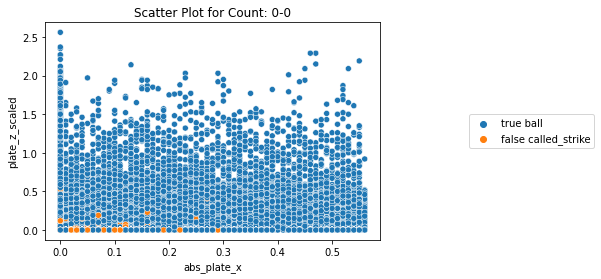

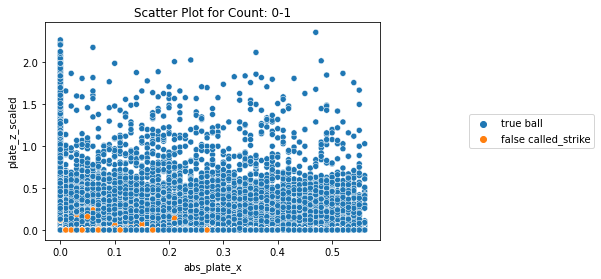

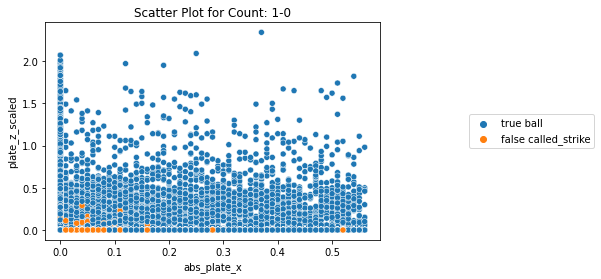

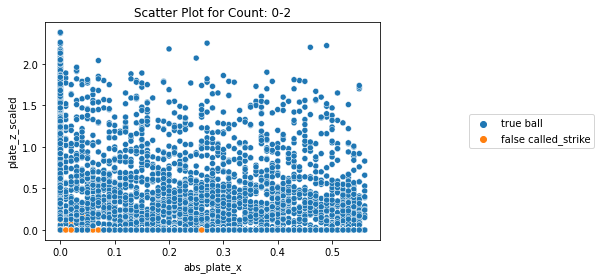

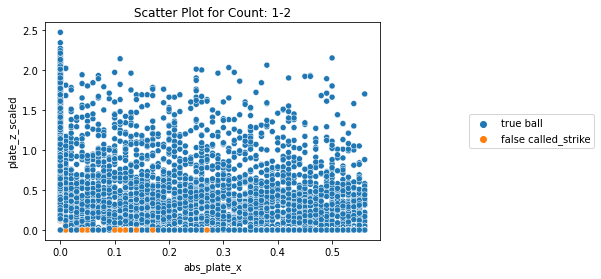

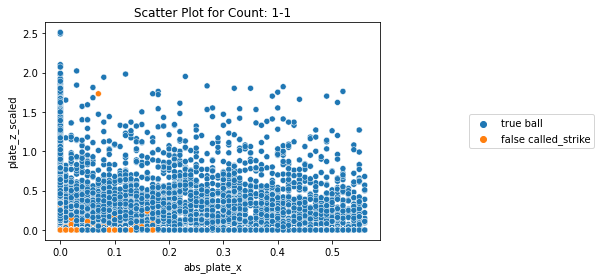

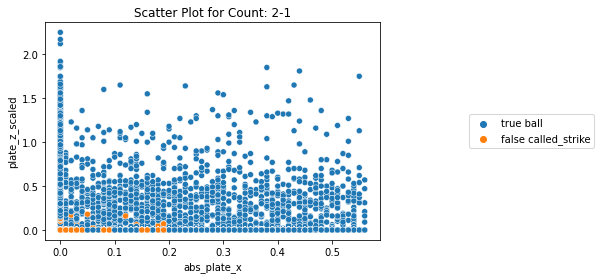

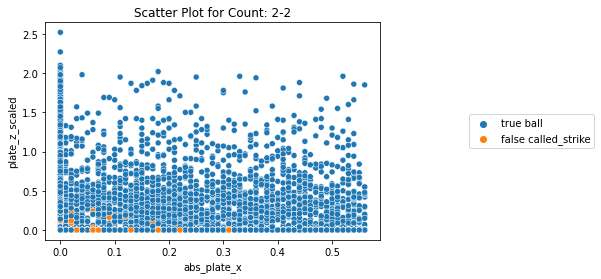

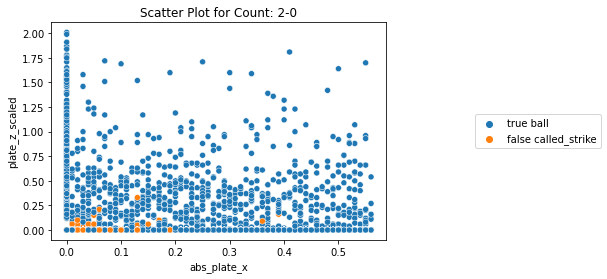

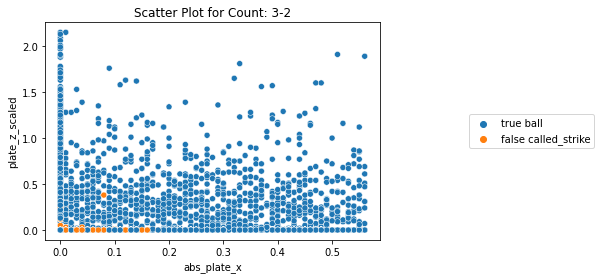

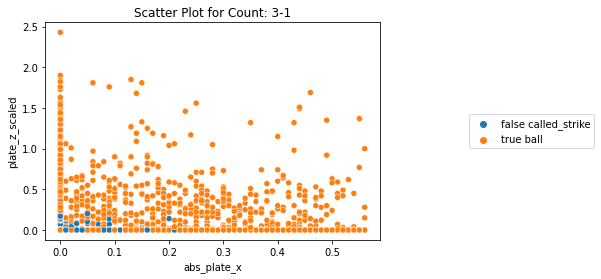

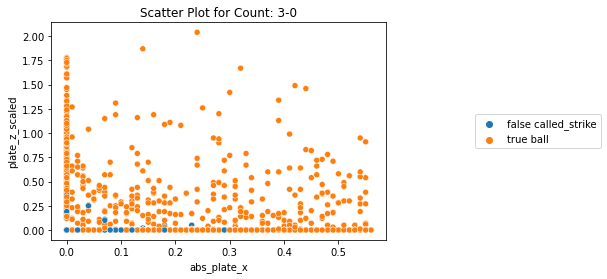

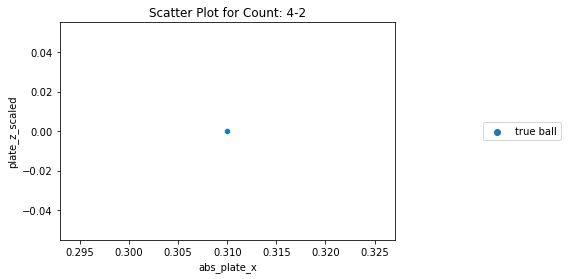

In [61]:
#creates scatter plots of horizontal and vertical distance outside strike zone for each count
#categorized by pitch type
for count in list(pitches['count'].unique()):
    plt.figure()  # Create a new figure for each plot
    sns.scatterplot(data=pitches[pitches['count'] == count], x='abs_plate_x', y='plate_z_scaled', hue='true_pitch')
    plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.title(f'Scatter Plot for Count: {count}')
    plt.show()  # Display the plot

In [62]:
#looks at descriptive stats for distance outside the strike zone variables for each count
for count in list(pitches['count'].unique()):
    print(count)
    print(pitches[pitches['count'] == count][['abs_plate_x','plate_z_scaled']].describe())

0-0
        abs_plate_x  plate_z_scaled
count  40320.000000    40320.000000
mean       0.150306        0.249313
std        0.170870        0.329506
min        0.000000        0.000000
25%        0.000000        0.000000
50%        0.080000        0.140000
75%        0.280000        0.390000
max        0.560000        2.560000
0-1
        abs_plate_x  plate_z_scaled
count  17181.000000    17181.000000
mean       0.158919        0.293925
std        0.177753        0.365592
min        0.000000        0.000000
25%        0.000000        0.000000
50%        0.090000        0.180000
75%        0.300000        0.460000
max        0.560000        2.360000
1-0
        abs_plate_x  plate_z_scaled
count  13399.000000    13399.000000
mean       0.152116        0.239015
std        0.171870        0.310217
min        0.000000        0.000000
25%        0.000000        0.000000
50%        0.080000        0.150000
75%        0.280000        0.390000
max        0.560000        2.340000
0-2
       abs_p

In [63]:
#calculates median horizontal distance outside of strike zone for pitches outside the strike zone horizontally
left_right_median = pitches[pitches['abs_plate_x']>0]['abs_plate_x'].median()

In [64]:
#calculates median vertical distance outside of strike zone for pitches outside the strike zone vertically
high_low_median = pitches[pitches['plate_z_scaled']>0]['plate_z_scaled'].median()

In [65]:
#removes count of 4-2 which makes no sense
pitches = pitches[pitches['count']!='4-2']

In [66]:
#creates a variable that replaces the count with the average batter woba for the 2023 season in that count
#a way of making a categorical variable numeric with the right spacing
woba_by_count = {'3-0':.673,'3-1':.572,'1-0':.411,'2-0':.404,'0-0':.403,'1-1':.382,'2-1':.380,'3-2':.374,'0-1':.358,'2-2':.199,'1-2':.182,'0-2':.175}

pitches['woba_by_count'] = pitches['count'].replace(woba_by_count)
pitches['woba_by_count'] = pitches['woba_by_count'].astype(float)

In [67]:
#creates a function that returns 1 if the distance outside of the strike zone horizontally or vertically is
#less than the median
def close_ball(df):
    if df['abs_plate_x']>left_right_median or df['plate_z_scaled']>high_low_median:
        return 0
    else:
        return 1

In [68]:
#applies function to create a variable
pitches['close_ball'] = pitches.apply(close_ball,axis=1)

In [69]:
#creates a new interaction term variable of the numeric count and whether the ball was close to the zone
pitches['woba_by_count*close_ball'] = pitches['woba_by_count']*pitches['close_ball']

In [70]:
#looks at incorrect strike percentage by count for close balls
pitches[pitches['close_ball']==1].groupby(by='count')['true_pitch'].value_counts(normalize=True)

count  true_pitch         
0-0    true ball              0.754549
       false called_strike    0.245451
0-1    true ball              0.860772
       false called_strike    0.139228
0-2    true ball              0.913956
       false called_strike    0.086044
1-0    true ball              0.747909
       false called_strike    0.252091
1-1    true ball              0.835496
       false called_strike    0.164504
1-2    true ball              0.893904
       false called_strike    0.106096
2-0    true ball              0.726419
       false called_strike    0.273581
2-1    true ball              0.793611
       false called_strike    0.206389
2-2    true ball              0.859056
       false called_strike    0.140944
3-0    true ball              0.683878
       false called_strike    0.316122
3-1    true ball              0.756778
       false called_strike    0.243222
3-2    true ball              0.827951
       false called_strike    0.172049
Name: true_pitch, dtype: float64

In [71]:
#creates a function that converts switch hitters into righties and lefties depending on the pitcher
def switch(df):
    if df['bats'] == 'B' and df['p_throws'] == 'R':
        return 'L'
    elif df['bats'] == 'B' and df['p_throws'] == 'L':
        return 'R'
    else:
        return df['bats']

In [72]:
#applies function to create a variable
pitches['bats'] = pitches.apply(switch,axis=1)

In [73]:
#creates a new variable that uses the horizontal and vertical distances outside the strike zone to calculate
#the euclidean distance outside the strike zone
pitches['euclid_dist'] = np.sqrt(pitches['abs_plate_x']**2 + pitches['plate_z_scaled']**2)

## Feature Analysis, Final Feature Engineering, Fine-Tuning of Model Components

In [74]:
#creates lists of initial numeric and categorical variables to be looked at as model candidates
num_vars = ['pfx_x','pfx_z','plate_x','plate_z_scaled','effective_speed','at_bat_number','weight','height','time_since_debut','run_diff','sz_height','height*hi_lo']
cat_vars = ['outs_when_up','inning_bins','birthCountry','batter_allstar','pitcher_allstar','high_or_low_pitch','handed_matchup','makeup_call_potential','count','on_base','ump_already_screwed']

In [75]:
#calculates incorrect strike percentage for entire dataset
pitches['true_pitch'].value_counts(normalize=True)

true ball              0.904852
false called_strike    0.095148
Name: true_pitch, dtype: float64

In [76]:
#looks at incorrect strike percentage by inning
pitches.groupby(by='inning')['true_pitch'].value_counts(normalize=True)

inning  true_pitch         
1       true ball              0.910417
        false called_strike    0.089583
2       true ball              0.907728
        false called_strike    0.092272
3       true ball              0.905932
        false called_strike    0.094068
4       true ball              0.906004
        false called_strike    0.093996
5       true ball              0.899784
        false called_strike    0.100216
6       true ball              0.901968
        false called_strike    0.098032
7       true ball              0.903283
        false called_strike    0.096717
8       true ball              0.904260
        false called_strike    0.095740
9       true ball              0.901325
        false called_strike    0.098675
10      true ball              0.906897
        false called_strike    0.093103
11      true ball              0.894472
        false called_strike    0.105528
12      true ball              0.959459
        false called_strike    0.040541
13      true

In [77]:
#looks at incorrect strike percentage for each category in each categorical variable
for cat in cat_vars:
    print(pitches.groupby(by=cat)['true_pitch'].value_counts(normalize=True))

outs_when_up  true_pitch         
0             true ball              0.902244
              false called_strike    0.097756
1             true ball              0.905770
              false called_strike    0.094230
2             true ball              0.906706
              false called_strike    0.093294
Name: true_pitch, dtype: float64
inning_bins  true_pitch         
beg          true ball              0.908075
             false called_strike    0.091925
end          true ball              0.903206
             false called_strike    0.096794
mid          true ball              0.902636
             false called_strike    0.097364
Name: true_pitch, dtype: float64
birthCountry  true_pitch         
Aruba         true ball              0.886316
              false called_strike    0.113684
Australia     true ball              0.934783
              false called_strike    0.065217
Bahamas       true ball              0.890785
              false called_strike    0.109215
Brazil     

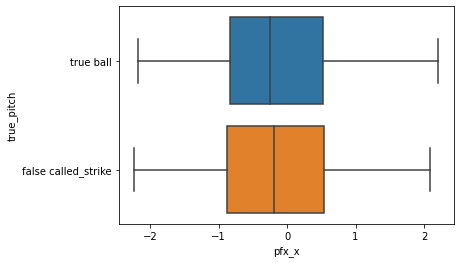

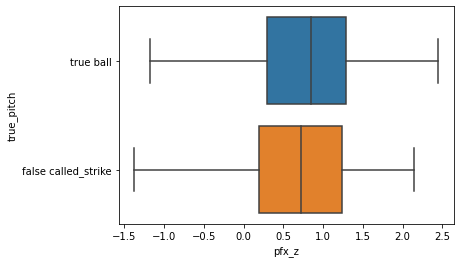

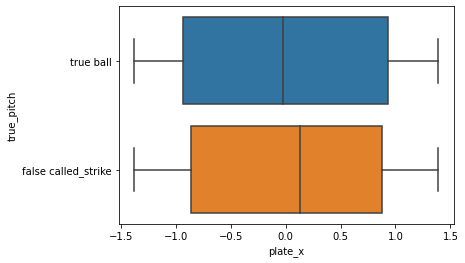

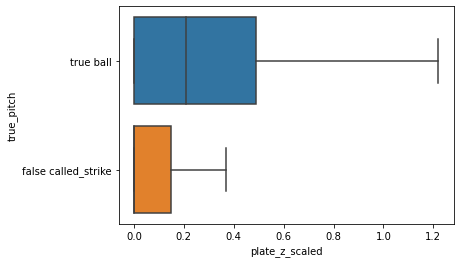

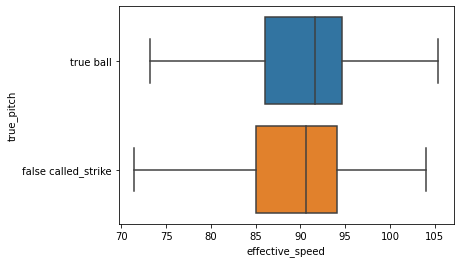

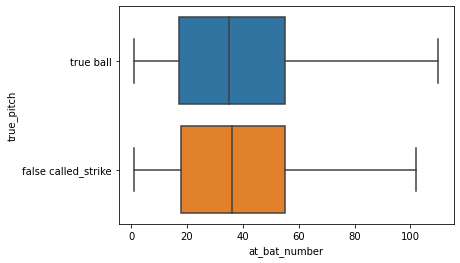

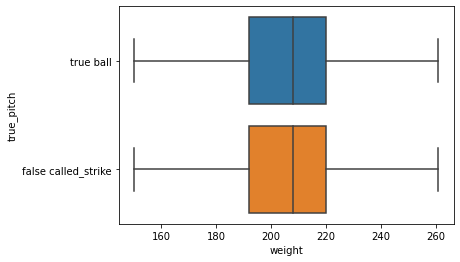

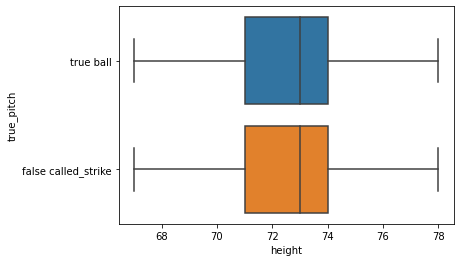

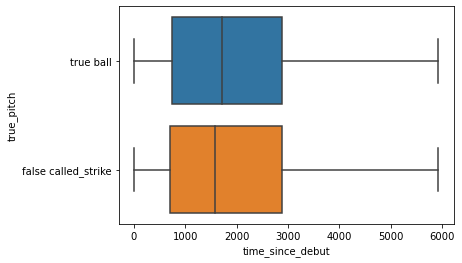

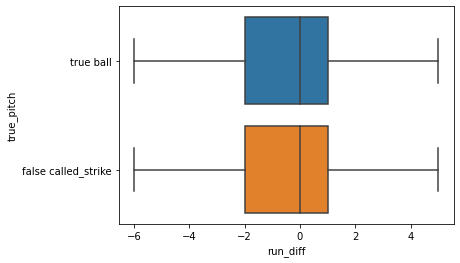

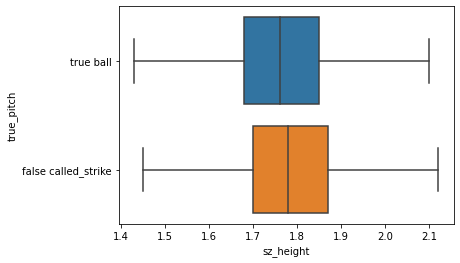

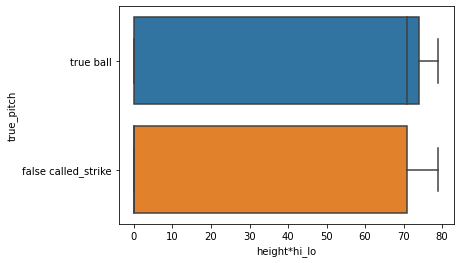

In [78]:
#looks at differences in numeric variables between true balls and incorrectly called strikes
for num in num_vars:
    plt.figure()
    sns.boxplot(data=pitches, x=num, y="true_pitch",showfliers=False)

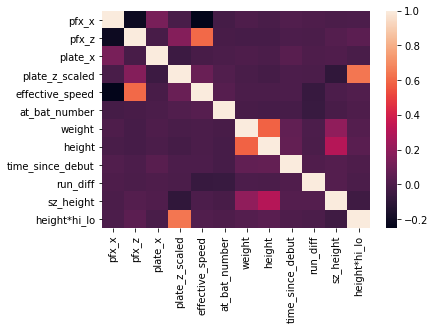

In [79]:
#looks at correlation matrix between numeric variables
sns.heatmap(pitches[num_vars].corr());

In [80]:
#checks correlation between height and weight
pitches['height'].corr(pitches['weight'])

0.5889590999422636

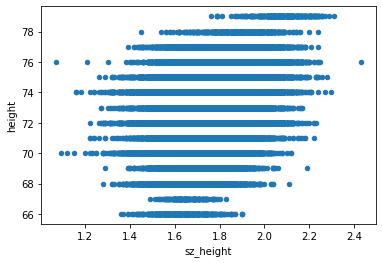

In [81]:
#looks at relationship between height and strike zone height
pitches.plot(x='sz_height',y='height',kind='scatter');

In [82]:
#creates variable that stores pitch type percentages grouped by at bat number in a game
at_bats = pitches.groupby(by='at_bat_number')['true_pitch'].value_counts(normalize=True).to_frame().reset_index(0)

In [83]:
#only keeps false called strike percentage
at_bats = at_bats[at_bats.index == 'false called_strike']

In [84]:
#renames as false call share
at_bats.rename({'true_pitch':'false call share'},axis=1,inplace=True)

In [85]:
#sets index as at bat number
at_bats.set_index('at_bat_number',inplace=True)

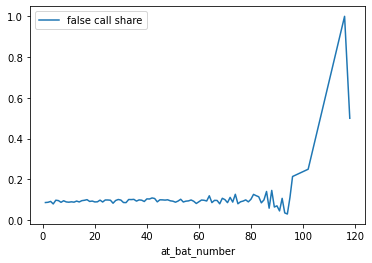

In [86]:
#plots at bat number versus false call share
at_bats.plot();

In [87]:
#looks at incorrect strike percentage grouped by inning bins
pitches.groupby(by='inning_bins')['true_pitch'].value_counts(normalize=True)

inning_bins  true_pitch         
beg          true ball              0.908075
             false called_strike    0.091925
end          true ball              0.903206
             false called_strike    0.096794
mid          true ball              0.902636
             false called_strike    0.097364
Name: true_pitch, dtype: float64

In [88]:
#looks at incorrect strike percentage grouped by alternate inning bins
pitches.groupby(by='alt_inning_bins')['true_pitch'].value_counts(normalize=True)

alt_inning_bins  true_pitch         
0                true ball              0.907588
                 false called_strike    0.092412
1                true ball              0.902188
                 false called_strike    0.097812
Name: true_pitch, dtype: float64

In [89]:
#looks at incorrect strike percentage grouped by run differential bins
pitches.groupby(by='run_diff_bins')['true_pitch'].value_counts(normalize=True)

run_diff_bins  true_pitch         
0              true ball              0.905731
               false called_strike    0.094269
1              true ball              0.898569
               false called_strike    0.101431
Name: true_pitch, dtype: float64

In [90]:
#creates interaction term variable between strike zone height and high or low pitch
pitches['sz_height*hi_lo'] = pitches['sz_height']*pitches['high_or_low_pitch']

In [91]:
#creates a function that splits on base combinations into bases loaded, nobody on base, and other
def on_base_bins(df):
    if df['on_base'] == '1-2-3':
        return 'bases_loaded'
    elif df['on_base'] == '_-_-_':
        return 'nobody_on'
    else:
        return 'other'

#applies function to create a new variable
pitches['on_base_bins'] = pitches.apply(on_base_bins,axis=1)

In [92]:
#creates a function that returns 1 if pitch is a false called strike and 0 if pitch is a true ball
def true_pitch_num(df):
    if df['true_pitch'] == 'true ball':
        return 0
    else:
        return 1

#applies function to create dependent variable
pitches['true_pitch_num'] = pitches.apply(true_pitch_num,axis=1)

In [93]:
#looks at correlation between horizontal distance outside strike zone (numeric) and 
#whether it was a close ball (categorical) to check for multicollinearity
from scipy import stats

stats.pointbiserialr(pitches['abs_plate_x'], pitches['close_ball'])

PointbiserialrResult(correlation=-0.4101883897983935, pvalue=0.0)

In [94]:
#looks at correlation between horizontal distance outside strike zone (numeric) and 
#whether it was a close ball (categorical) to check for multicollinearity
stats.pointbiserialr(pitches['plate_z_scaled'], pitches['close_ball'])

PointbiserialrResult(correlation=-0.40686479336785225, pvalue=0.0)

## Variable Finalizing, Train-Test Split, One-Hot Encoding

In [95]:
#define Y in model
Y = pitches['true_pitch_num']

In [96]:
#define X numeric and categorical variables and variables to be one hot encoded
final_num_vars = ['pfx_x','pfx_z','plate_x','plate_z_scaled','effective_speed','at_bat_number','weight','height','time_since_debut','run_diff','sz_height','height*hi_lo','abs_plate_x','abs_pfx_x','sz_height*hi_lo','woba_by_count*close_ball','euclid_dist']
final_cat_vars = ['inning_bins','birthCountry','batter_allstar','pitcher_allstar','high_or_low_pitch','handed_matchup','makeup_call_potential','count','on_base','run_diff_bins','woba_by_count','alt_inning_bins','ump_already_screwed','close_ball']
ohe_vars=['outs_when_up','bats','on_base_bins']

In [97]:
#create a list of all variables
final_all_vars = final_num_vars + final_cat_vars + ohe_vars

#define X variables in model
X = pitches[final_all_vars]

In [98]:
#drop unneeded columns after feature analysis
X = X.drop(['plate_x','pfx_x','run_diff','inning_bins','at_bat_number','count','handed_matchup','birthCountry','on_base','makeup_call_potential','ump_already_screwed','height','sz_height','woba_by_count*close_ball','close_ball','plate_z_scaled','abs_plate_x','sz_height*hi_lo'],axis=1)

In [99]:
#import package for train test split
from sklearn.model_selection import train_test_split

In [100]:
#perform train test split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [101]:
#import one hot encoder
from sklearn.preprocessing import OneHotEncoder

In [102]:
#perform one hot encoding
ohe = OneHotEncoder(drop=[0,'R','other'])
X_train_ohe = ohe.fit_transform(X_train[['outs_when_up','bats','on_base_bins']])
X_test_ohe = ohe.transform(X_test[['outs_when_up','bats','on_base_bins']])

In [103]:
#drop original columns
X_train = X_train.drop(['outs_when_up','bats','on_base_bins'],axis=1)
X_test = X_test.drop(['outs_when_up','bats','on_base_bins'],axis=1)

In [104]:
#turn one hot encoded columns into dataframe
X_train_ohe = pd.DataFrame(X_train_ohe.toarray(),columns=ohe.get_feature_names(),index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe.toarray(),columns=ohe.get_feature_names(),index=X_test.index)

In [105]:
#add one hot encoded dataframe to X train and X test
X_train = pd.concat([X_train,X_train_ohe], axis=1)
X_test = pd.concat([X_test,X_test_ohe],axis=1)

## Decision Trees

In [106]:
#import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

In [107]:
#instantiate decision tree
dt = DecisionTreeClassifier(max_depth=4,class_weight='balanced',random_state=42)

In [108]:
#fit tree
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)

In [109]:
#calculate precision and recall scores for model
from sklearn.metrics import precision_score,recall_score

y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_p = precision_score(y_train,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_train,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

Train Precision: 0.2730194123819517
Test Precision: 0.27473698228792115
Train Recall: 0.8535110199897489
Test Recall: 0.8461853978671042


In [110]:
#calculate recall scores from cross validation
from sklearn.model_selection import cross_val_score

recall = cross_val_score(dt,X_train,y_train,scoring='recall')
recall

array([0.83956945, 0.8595592 , 0.86981035, 0.8498206 , 0.86468478])

In [111]:
#calculate cross validation recall mean
recall.mean()

0.8566888774987186

In [112]:
#run grid search to extract best depth of decision tree based on optimal F1 score
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': range(1,30)}

grid_search = GridSearchCV(dt, param_grid, cv=5,scoring='f1')
grid_search.fit(X_train, y_train)

#Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

{'max_depth': 4}

In [113]:
#look at best F1 score
best_score

0.4093833493219557

In [114]:
#create a list of decision tree feature importances
importances = list(dt.feature_importances_)

In [115]:
#get list of X variable names
names = list(X_train.columns)

In [116]:
#zip names and importances into a dictionary
importance_names = dict(zip(names,importances))

In [117]:
#sort the dictionary from most important to least
importance_names = dict(sorted(importance_names.items(),key = lambda x:x[1],reverse=True))

In [118]:
#look at feature importances
importance_names

{'euclid_dist': 0.9612748133008144,
 'woba_by_count': 0.024184713472341957,
 'height*hi_lo': 0.01274854127068467,
 'effective_speed': 0.0017919319561589709,
 'pfx_z': 0.0,
 'weight': 0.0,
 'time_since_debut': 0.0,
 'abs_pfx_x': 0.0,
 'batter_allstar': 0.0,
 'pitcher_allstar': 0.0,
 'high_or_low_pitch': 0.0,
 'run_diff_bins': 0.0,
 'alt_inning_bins': 0.0,
 'x0_1': 0.0,
 'x0_2': 0.0,
 'x1_L': 0.0,
 'x2_bases_loaded': 0.0,
 'x2_nobody_on': 0.0}

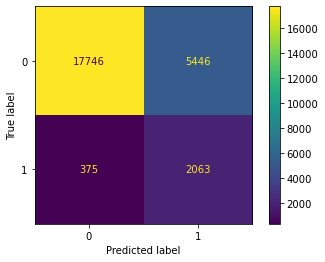

In [119]:
#import and plot confusion matrix of decision tree model on test set
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(dt,X_test,y_test);

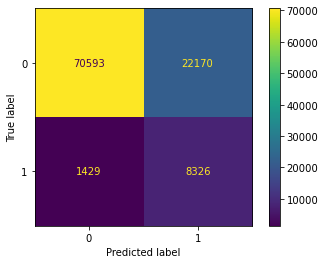

In [120]:
#plot confusion matrix of decision tree model on train set
plot_confusion_matrix(dt,X_train,y_train);

In [121]:
#get train and test precision and recall scores for different decision tree depths
train_p_list = []
test_p_list = []
train_r_list = []
test_r_list = []
max_depth_list = list(range(1,30))

for i in range(1,30):
    dt = DecisionTreeClassifier(max_depth=i,class_weight='balanced',random_state=42)
    dt.fit(X_train,y_train)
    
    y_train_pred = dt.predict(X_train)
    y_test_pred = dt.predict(X_test)
    
    train_p = precision_score(y_train,y_train_pred)
    test_p = precision_score(y_test,y_test_pred)
    train_r = recall_score(y_train,y_train_pred)
    test_r = recall_score(y_test,y_test_pred)
    
    train_p_list.append(train_p)
    test_p_list.append(test_p)
    train_r_list.append(train_r)
    test_r_list.append(test_r) 

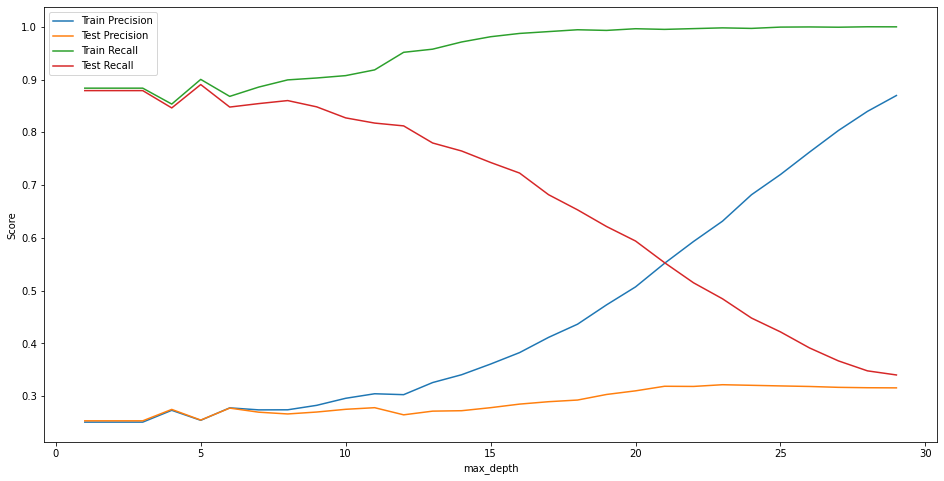

In [122]:
#plot train and test precision and recall scores for different decision tree depths
fig,ax = plt.subplots(figsize=(16,8))

ax.plot(max_depth_list,train_p_list,label='Train Precision')
ax.plot(max_depth_list,test_p_list,label='Test Precision')
ax.plot(max_depth_list,train_r_list,label='Train Recall')
ax.plot(max_depth_list,test_r_list,label='Test Recall')
ax.set_xlabel('max_depth')
ax.set_ylabel('Score')
ax.legend();

In [123]:
#import random under sampler
from imblearn.under_sampling import RandomUnderSampler

In [124]:
#fit under sampler on train set
under = RandomUnderSampler(random_state=42)
X_u, y_u = under.fit_resample(X_train,y_train)

In [125]:
#instantiate decision tree
dt_u = DecisionTreeClassifier(max_depth=5,random_state=42)

In [126]:
#fit under sampled data
dt_u.fit(X_u,y_u)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [127]:
#calculate precision and recall scores for model
y_train_pred = dt_u.predict(X_u)
y_test_pred = dt_u.predict(X_test)

train_p = precision_score(y_u,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_u,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

Train Precision: 0.767985927880387
Test Precision: 0.25605863577254995
Train Recall: 0.8951307022039979
Test Recall: 0.8884331419196062


In [128]:
#calculate recall scores from cross validation
recall = cross_val_score(dt_u,X_u,y_u,scoring='recall')
recall

array([0.90773962, 0.90466427, 0.86724757, 0.8595592 , 0.89441312])

In [129]:
#calculate recall mean
recall.mean()

0.8867247565351102

In [130]:
#run grid search to extract best depth of decision tree based on optimal F1 score
param_grid = {'max_depth': range(1,30)}

grid_search = GridSearchCV(dt_u, param_grid, cv=5,scoring='f1')
grid_search.fit(X_u, y_u)

#Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

{'max_depth': 5}

In [131]:
#look at best F1 score
best_score

0.8197783842259913

In [132]:
#create a list of decision tree feature importances
importances = list(dt_u.feature_importances_)

In [133]:
#get list of X variable names
names = list(X_train.columns)

In [134]:
#zip names and importances into a dictionary
importance_names = dict(zip(names,importances))

In [135]:
#sort the dictionary from most important to least
importance_names = dict(sorted(importance_names.items(),key = lambda x:x[1],reverse=True))

In [136]:
#look at feature importances
importance_names

{'euclid_dist': 0.9441388960928055,
 'woba_by_count': 0.03401217553312067,
 'height*hi_lo': 0.014223659259189695,
 'effective_speed': 0.005018992793068751,
 'x1_L': 0.0014081508641297054,
 'pfx_z': 0.000693442599162928,
 'x2_nobody_on': 0.0005046828585227995,
 'weight': 0.0,
 'time_since_debut': 0.0,
 'abs_pfx_x': 0.0,
 'batter_allstar': 0.0,
 'pitcher_allstar': 0.0,
 'high_or_low_pitch': 0.0,
 'run_diff_bins': 0.0,
 'alt_inning_bins': 0.0,
 'x0_1': 0.0,
 'x0_2': 0.0,
 'x2_bases_loaded': 0.0}

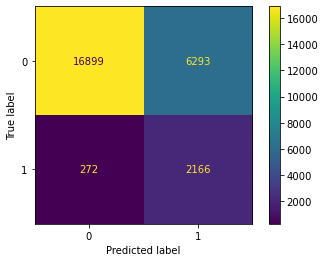

In [137]:
#plot confusion matrix of decision tree model on test set
plot_confusion_matrix(dt_u,X_test,y_test);

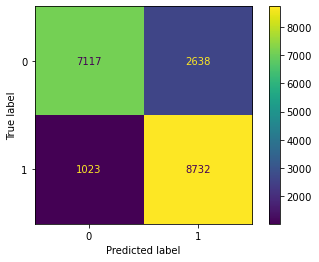

In [138]:
#plot confusion matrix of decision tree model on train set
plot_confusion_matrix(dt_u,X_u,y_u);

In [139]:
#get train and test precision and recall scores for different decision tree depths
train_p_list = []
test_p_list = []
train_r_list = []
test_r_list = []
max_depth_list = list(range(1,30))

for i in range(1,30):
    dt_u = DecisionTreeClassifier(max_depth=i,random_state=42)
    dt_u.fit(X_u,y_u)
    
    y_train_pred = dt_u.predict(X_u)
    y_test_pred = dt_u.predict(X_test)
    
    train_p = precision_score(y_u,y_train_pred)
    test_p = precision_score(y_test,y_test_pred)
    train_r = recall_score(y_u,y_train_pred)
    test_r = recall_score(y_test,y_test_pred)
    
    train_p_list.append(train_p)
    test_p_list.append(test_p)
    train_r_list.append(train_r)
    test_r_list.append(test_r)  

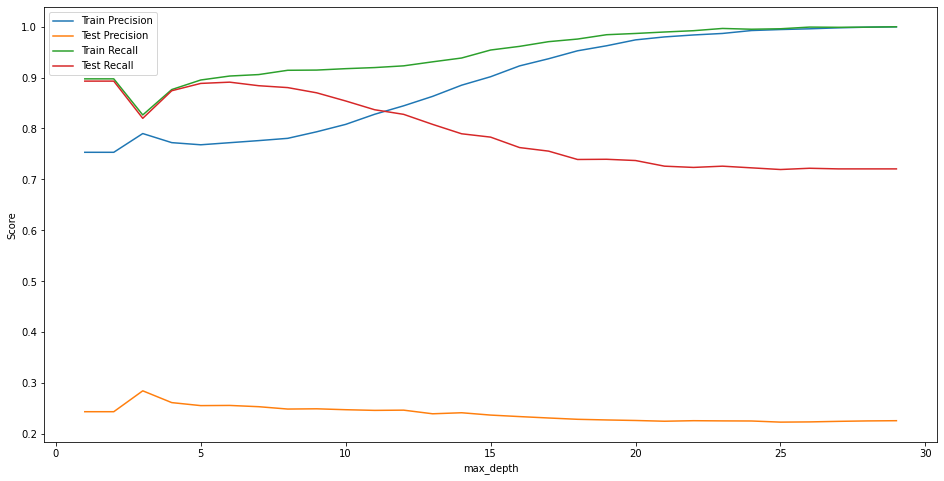

In [140]:
#plot train and test precision and recall scores for different decision tree depths
fig,ax = plt.subplots(figsize=(16,8))

ax.plot(max_depth_list,train_p_list,label='Train Precision')
ax.plot(max_depth_list,test_p_list,label='Test Precision')
ax.plot(max_depth_list,train_r_list,label='Train Recall')
ax.plot(max_depth_list,test_r_list,label='Test Recall')
ax.set_xlabel('max_depth')
ax.set_ylabel('Score')
ax.legend();

## Logistic Regression

In [141]:
#import Logistic Regression and Standard Scaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [142]:
#split X train columns into categorical and numeric
cat_cols = []
num_cols = []
for col in list(X_train.columns):
    if X_train[col].max()==1:
        cat_cols.append(col)
    else:
        num_cols.append(col)
print(cat_cols)
print(num_cols)

['batter_allstar', 'pitcher_allstar', 'high_or_low_pitch', 'run_diff_bins', 'alt_inning_bins', 'x0_1', 'x0_2', 'x1_L', 'x2_bases_loaded', 'x2_nobody_on']
['pfx_z', 'effective_speed', 'weight', 'time_since_debut', 'height*hi_lo', 'abs_pfx_x', 'euclid_dist', 'woba_by_count']


In [143]:
#instantiate standard scaler and apply to numeric columns of train and test set
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

In [144]:
#create dataframes of scaled variables
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train[num_cols].columns,index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test[num_cols].columns,index=X_test.index)

In [145]:
#add scaled variables to dataframe of categorical columns
X_train_scaled = pd.concat([X_train_scaled,X_train[cat_cols]], axis=1)
X_test_scaled = pd.concat([X_test_scaled,X_test[cat_cols]],axis=1)

In [146]:
#instantiate logistic regression model
log_model = LogisticRegression(C=1,class_weight='balanced',max_iter=200,random_state=42)

In [147]:
#fit log reg on train set
log_model.fit(X_train_scaled,y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=200, random_state=42)

In [148]:
#calculate precision and recall scores for model
y_train_pred = log_model.predict(X_train_scaled)
y_test_pred = log_model.predict(X_test_scaled)

train_p = precision_score(y_train,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_train,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

Train Precision: 0.2721707585670791
Test Precision: 0.27358490566037735
Train Recall: 0.8614044079958996
Test Recall: 0.8564397046759639


In [149]:
#calculate recall scores from cross validation
recall = cross_val_score(log_model,X_train_scaled,y_train,scoring='recall')
recall

array([0.84725782, 0.87596105, 0.86417222, 0.86622245, 0.85084572])

In [150]:
#calculate cross validation recall mean
recall.mean()

0.8608918503331624

In [151]:
#run grid search to tune logistic regression for best F1 score
param_grid = {'max_iter': [100,200,500,1000],'C': [0.001, 0.01, 0.1,1],'class_weight':['balanced']}

grid_search = GridSearchCV(log_model, param_grid, cv=5,scoring='f1')
grid_search.fit(X_train_scaled, y_train)

#Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

{'C': 1, 'class_weight': 'balanced', 'max_iter': 100}

In [152]:
#look at best F1 score
best_score

0.4132672028332817

In [153]:
#create a dictionary with column names and logistic regression coefficients
coef_dict = {}
for coef, feat in zip(log_model.coef_[0,:],X_train_scaled.columns):
    coef_dict[feat] = coef
coef_dict = dict(sorted(coef_dict.items(),key=lambda x:x[1],reverse=True))
coef_dict

{'height*hi_lo': 0.6783373105966116,
 'woba_by_count': 0.3501926145572471,
 'x2_bases_loaded': 0.30053613489495346,
 'x2_nobody_on': 0.1119290503225138,
 'alt_inning_bins': 0.09741160381349553,
 'run_diff_bins': 0.06606036022454174,
 'pitcher_allstar': 0.03929111868789374,
 'weight': 0.005067298822414005,
 'x0_2': 0.004950601590812447,
 'pfx_z': -0.004217712396879446,
 'x0_1': -0.007234831428564746,
 'abs_pfx_x': -0.010128927029346072,
 'time_since_debut': -0.01426367450492481,
 'batter_allstar': -0.08623226018171327,
 'effective_speed': -0.16414669749810912,
 'x1_L': -0.19514036314809294,
 'high_or_low_pitch': -1.041541168835063,
 'euclid_dist': -3.8065330169422555}

In [154]:
#create a dictionary with column names and interpretable odds
odds_dict = {}
for feat,coef in coef_dict.items():
    odds_dict[feat] = round((np.exp(coef)-1)*100,2)

In [155]:
#look at odds
odds_dict

{'height*hi_lo': 97.06,
 'woba_by_count': 41.93,
 'x2_bases_loaded': 35.06,
 'x2_nobody_on': 11.84,
 'alt_inning_bins': 10.23,
 'run_diff_bins': 6.83,
 'pitcher_allstar': 4.01,
 'weight': 0.51,
 'x0_2': 0.5,
 'pfx_z': -0.42,
 'x0_1': -0.72,
 'abs_pfx_x': -1.01,
 'time_since_debut': -1.42,
 'batter_allstar': -8.26,
 'effective_speed': -15.14,
 'x1_L': -17.73,
 'high_or_low_pitch': -64.71,
 'euclid_dist': -97.78}

In [156]:
#import precision recall curve and area under the curve metrics
from sklearn.metrics import precision_recall_curve, auc

#calculate AUC
y_score = log_model.predict_proba(X_test_scaled)[:,1]
precision,recall,thresholds = precision_recall_curve(y_test,y_score)
print('AUC: {}'.format(auc(recall, precision)))

AUC: 0.4383744589991653


In [157]:
#calculate junk classifier for precision recall curve, which is equal to positive share of train set
junk = y_train.value_counts(normalize=True)[1]

In [158]:
#create variable equal to true ball percentage for later use
majority = y_train.value_counts(normalize=True)[0]

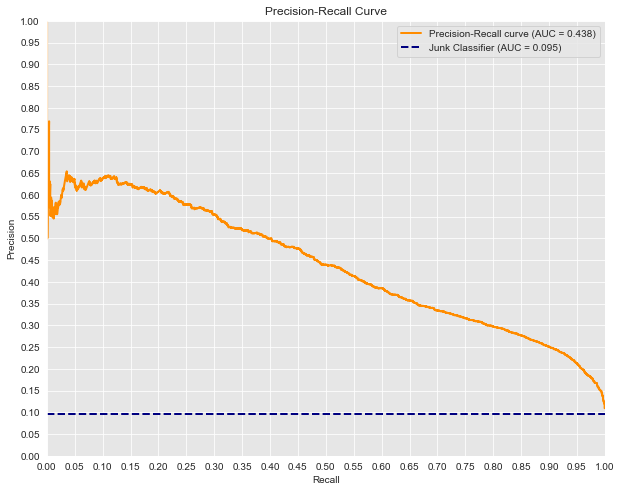

In [159]:
# Plot a Precision-Recall Curve
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label=f'Precision-Recall curve (AUC = {round(auc(recall,precision),3)})')
plt.plot([0, 1], [0.0951, .0951], color='navy', lw=lw, linestyle='--',label=f'Junk Classifier (AUC = {round(junk,3)})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [160]:
#create a variable that calculates each threshold's F1 score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f1 score
ix = np.nanargmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]}')

Best Threshold=0.7894359286796182, F-Score=0.4744945279168985


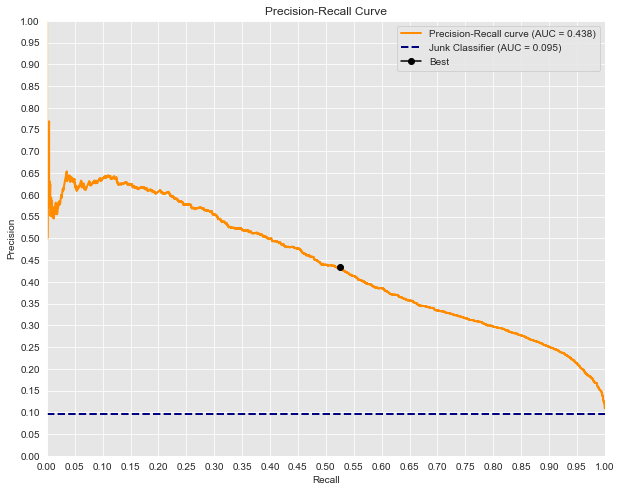

In [161]:
# Plot a Precision-Recall Curve with the best threshold as a black dot
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label=f'Precision-Recall curve (AUC = {round(auc(recall,precision),3)})')
plt.plot([0, 1], [0.0951, .0951], color='navy', lw=lw, linestyle='--',label=f'Junk Classifier (AUC = {round(junk,3)})')
plt.plot(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [162]:
#calculate probability predictions for test set
proba_predictions = log_model.predict_proba(X_test_scaled)

# Set the threshold (e.g., 0.5) to classify instances into classes
threshold = thresholds[ix]

# Convert probabilities to class labels based on the threshold
predicted_labels = (proba_predictions[:, 1] >= threshold).astype(int)

In [163]:
#calculate recall score for best F1 threshold
recall_score(y_test,predicted_labels)

0.5246103363412633

In [164]:
#calculate precision score for best F1 threshold
precision_score(y_test,predicted_labels)

0.43311886217406026

In [165]:
#import pipeline and column transformer packages with the intent being
#to create a logistic regression with the under sampled data
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Create the pipeline
ct = ColumnTransformer([
        ('num_cols',StandardScaler(),num_cols)],
        remainder='passthrough')

pipe = Pipeline([('ct',ct),
                ('log_model', LogisticRegression(random_state=42))
                ])

In [166]:
# Create the grid parameter
grid = {'log_model__max_iter': [100,200,500,1000],'log_model__C': [0.001, 0.01, 0.1,1]}


# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=pipe, 
                          param_grid=grid, 
                          scoring='f1', 
                          cv=5)

# Fit using grid search
gridsearch.fit(X_u, y_u)

#Get best parameters and score
best_params = gridsearch.best_params_
best_score = gridsearch.best_score_
print(best_params)
print(best_score)

# Calculate the precision and recall scores
y_train_pred = gridsearch.predict(X_u)
y_test_pred = gridsearch.predict(X_test)

train_p = precision_score(y_u,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_u,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

{'log_model__C': 0.01, 'log_model__max_iter': 100}
0.8202084754401803
Train Precision: 0.7776245633388491
Test Precision: 0.2677044787546255
Train Recall: 0.8671450538185546
Test Recall: 0.8605414273995078


## Random Forest

In [167]:
#import random forest classifier, instantiate random forest model, and fit on train data
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300,max_depth=9,random_state=42)
clf.fit(X_u,y_u)

RandomForestClassifier(max_depth=9, n_estimators=300, random_state=42)

In [168]:
#evaluate model by looking at precision and recall scores on train and test sets
y_train_pred = clf.predict(X_u)
y_test_pred = clf.predict(X_test)

train_p = precision_score(y_u,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_u,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

Train Precision: 0.8000540637952784
Test Precision: 0.26947315351651124
Train Recall: 0.9101998974884674
Test Recall: 0.8769483182936834


In [169]:
#run grid search to tune random forest for best recall score
param_grid = {'max_depth': range(2,10),'n_estimators': [100,200,300,400,500]}

grid_search = GridSearchCV(clf, param_grid, cv=5,scoring='f1')
grid_search.fit(X_u, y_u)

#Get the best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

{'max_depth': 9, 'n_estimators': 300}

In [170]:
#look at best recall score with optimal parameters
best_score

0.8256254182968285

In [171]:
#similar to decision tree, look to see which columns had the highest feature importances
importances = list(clf.feature_importances_)
names = list(X_u.columns)
importance_names = dict(zip(names,importances))
importance_names = dict(sorted(importance_names.items(),key = lambda x:x[1],reverse=True))
importance_names

{'euclid_dist': 0.6849572597516087,
 'height*hi_lo': 0.06924353935681138,
 'high_or_low_pitch': 0.05693477264110298,
 'woba_by_count': 0.056456384789287654,
 'effective_speed': 0.025910666332605876,
 'pfx_z': 0.023920950239790507,
 'time_since_debut': 0.0224391704030021,
 'abs_pfx_x': 0.021052083365044834,
 'weight': 0.015921273626425526,
 'x1_L': 0.004968805089010846,
 'x2_nobody_on': 0.0026667321913787117,
 'alt_inning_bins': 0.002644575815350911,
 'x0_2': 0.0024131654614384128,
 'batter_allstar': 0.0022926345782834636,
 'x0_1': 0.002285311503753111,
 'pitcher_allstar': 0.0022058349959004713,
 'run_diff_bins': 0.0021846095478463244,
 'x2_bases_loaded': 0.0015022303113582092}

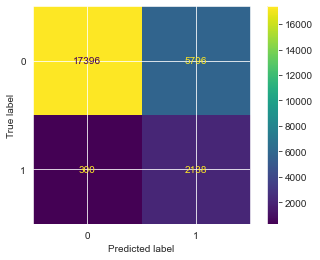

In [172]:
#plot confusion matrix for random forest model test set
plot_confusion_matrix(clf,X_test,y_test);

In [173]:
#get train and test precision and recall scores for different max depths
train_p_list = []
test_p_list = []
train_r_list = []
test_r_list = []
max_depth_list = list(range(1,10))

for i in range(1,10):
    clf = RandomForestClassifier(n_estimators=300,max_depth=i,random_state=42)
    clf.fit(X_u,y_u)
    
    y_train_pred = clf.predict(X_u)
    y_test_pred = clf.predict(X_test)

    train_p = precision_score(y_u,y_train_pred)
    test_p = precision_score(y_test,y_test_pred)
    train_r = recall_score(y_u,y_train_pred)
    test_r = recall_score(y_test,y_test_pred)
    
    train_p_list.append(train_p)
    test_p_list.append(test_p)
    train_r_list.append(train_r)
    test_r_list.append(test_r)  

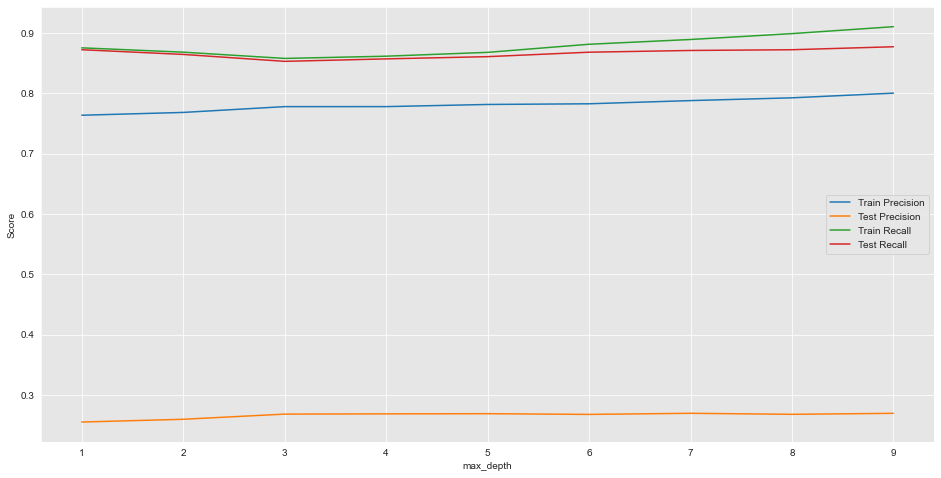

In [174]:
#plot train and test precision and recall scores for different max depths
fig,ax = plt.subplots(figsize=(16,8))

ax.plot(max_depth_list,train_p_list,label='Train Precision')
ax.plot(max_depth_list,test_p_list,label='Test Precision')
ax.plot(max_depth_list,train_r_list,label='Train Recall')
ax.plot(max_depth_list,test_r_list,label='Test Recall')
ax.set_xlabel('max_depth')
ax.set_ylabel('Score')
ax.legend();

## Neural Network

In [175]:
#install package for tensorflow to work
!pip install pyOpenSSL --upgrade

In [176]:
#import neural network packages
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RecallAtPrecision

In [177]:
#set up neural network layers
model=Sequential()

model.add(Dense(18,activation='relu',input_dim=18))
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
#compile model
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['Recall','Precision'])
#set early stopping criteria
early_stop = EarlyStopping(monitor='recall',min_delta=.001,verbose=1,patience=10,mode='max',restore_best_weights=True)
#fit model on train set
results = model.fit(X_train_scaled,y_train,class_weight={0:1/majority,1:1/junk},callbacks=[early_stop],epochs=50,batch_size=500,verbose=1)

Epoch 1/50
206/206 [==============================] - 0s 812us/step - loss: 1.1073 - recall: 0.7710 - precision: 0.1910
Epoch 2/50
206/206 [==============================] - 0s 761us/step - loss: 0.8833 - recall: 0.8455 - precision: 0.2584
Epoch 3/50
206/206 [==============================] - 0s 790us/step - loss: 0.8441 - recall: 0.8549 - precision: 0.2726
Epoch 4/50
206/206 [==============================] - 0s 725us/step - loss: 0.8344 - recall: 0.8536 - precision: 0.2733
Epoch 5/50
206/206 [==============================] - 0s 717us/step - loss: 0.8291 - recall: 0.8580 - precision: 0.2729
Epoch 6/50
206/206 [==============================] - 0s 730us/step - loss: 0.8255 - recall: 0.8575 - precision: 0.2730
Epoch 7/50
206/206 [==============================] - 0s 718us/step - loss: 0.8223 - recall: 0.8600 - precision: 0.2731
Epoch 8/50
206/206 [==============================] - 0s 712us/step - loss: 0.8202 - recall: 0.8593 - precision: 0.2747
Epoch 9/50
206/206 [====================

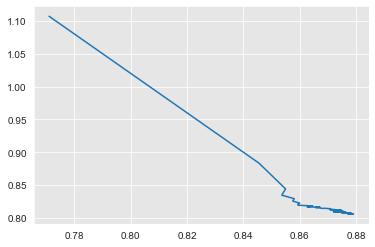

In [178]:
#plot loss function (Y-axis) versus recall score (X-axis)
plt.plot(results.history['recall'],results.history['loss']);

In [179]:
#evaluate model by looking at precision and recall scores on train and test sets
y_train_pred = (model.predict(X_train_scaled) > 0.5).astype(int)
y_test_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

train_p = precision_score(y_train,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_train,y_train_pred)
test_r = recall_score(y_test,y_test_pred)


print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

Train Precision: 0.26960382943881084
Test Precision: 0.26906860866232274
Train Recall: 0.8776012301383905
Test Recall: 0.8638228055783429


In [180]:
#look at F1 score for neural network model
from sklearn.metrics import f1_score
f1_score(y_test,y_test_pred)

0.4103263516804676

In [181]:
#get train and test f1 scores for different batch sizes
batch_size_list = range(100,1000,50)
train_f1_list = []
test_f1_list = []
for i in batch_size_list:
    results = model.fit(X_train_scaled,y_train,class_weight={0:1/majority,1:1/junk},callbacks=[early_stop],epochs=50,batch_size=i,verbose=0)
    y_train_pred = (model.predict(X_train_scaled) > 0.5).astype(int)
    y_test_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    train_f1 = f1_score(y_train,y_train_pred)
    test_f1 = f1_score(y_test,y_test_pred)
    train_f1_list.append(train_f1)
    test_f1_list.append(test_f1)

Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00012: early s

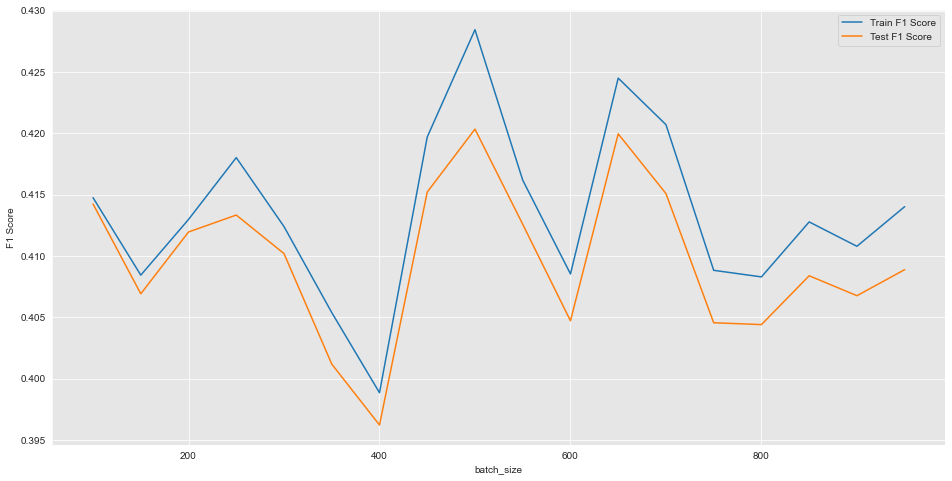

In [182]:
#plot train and test f1 scores for different batch sizes
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(batch_size_list,train_f1_list,label='Train F1 Score')
ax.plot(batch_size_list,test_f1_list,label='Test F1 Score')
ax.set_xlabel('batch_size')
ax.set_ylabel('F1 Score')
ax.legend();

## XGBoost

In [184]:
#import XGBoost
import xgboost as xgb

In [185]:
#creates train and test matrices
dtrain = xgb.DMatrix(X_u, label=y_u)
dtest = xgb.DMatrix(X_test,label=y_test)

In [186]:
#trains XGBoost model on under sampled data
params={'max_depth':6}

xgb_model = xgb.train(params,dtrain)

In [187]:
#evaluates model by looking at train and test recall and precision scores
y_train_pred = (xgb_model.predict(dtrain) > 0.5).astype(int)
y_test_pred = (xgb_model.predict(dtest) > 0.5).astype(int)

train_p = precision_score(y_u,y_train_pred)
test_p = precision_score(y_test,y_test_pred)
train_r = recall_score(y_u,y_train_pred)
test_r = recall_score(y_test,y_test_pred)

print(f'Train Precision: {train_p}')
print(f'Test Precision: {test_p}')
print(f'Train Recall: {train_r}')
print(f'Test Recall: {test_r}')

Train Precision: 0.7937135159407275
Test Precision: 0.26904702036711087
Train Recall: 0.9059969246540236
Test Recall: 0.8777686628383922
